# FINAL NPZD PROTOTYPE

# NOTE:

actually assemble all variables involved with a flux, and register from there!
add that extra level of complexity! so the problem if one has a dim and another doesn't

here list of vars supplied and flux routing could happen!!!

do this!

also,
think again how to use groups in the cleanest way possible!




In [1]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra

In [2]:
from phydra.components.variables import SV, SVArray

In [3]:
from phydra.components.fluxes import (LinearForcingInput,
                                      LinearMortality,
                                      MonodGrowth,
                                      MultiLimGrowth, Monod_ML,
                                      ListInputFlux
                                     )
from phydra.components.forcings import ConstantForcing, GlobalSlabClimatologyForcing

In [4]:
import numpy as np

np.warnings.filterwarnings('error', category=np.VisibleDeprecationWarning)

In [5]:
NPZD = phydra.create({'Nutrient':SV,
                      'Nutrient2':SV,
                      'Phytoplankton':SV,

                      'Input':LinearForcingInput,                       
                      'Growth':MultiLimGrowth,
                      'Monod':Monod_ML,
                      'Mortality': LinearMortality,
                      
                      # HERE NEED TO ADD THIS:
                      #'N0':GlobalSlabClimatologyForcing,
                      'N0':ConstantForcing,
                      
                      'ListInputFlux':ListInputFlux,
                     })

In [6]:
NPZD

<xsimlab.Model (12 processes, 23 inputs)>
Core
    solver_type       [in]
Time
    time              [in] ('input_time',) sequence of time points ...
Nutrient
    var_init          [in] initial value / basic state variable
    var_label         [in] label / basic state variable
Nutrient2
    var_label         [in] label / basic state variable
    var_init          [in] initial value / basic state variable
Phytoplankton
    var_init          [in] initial value / basic state variable
    var_label         [in] label / basic state variable
N0
    forcing_label     [in] label / 
    value             [in] constant value of forcing
Input
    forcing           [in] label reference / forcing affecting flux
    var               [in] label reference / variable affected by flux
    rate              [in] linear rate of change
Monod
    resource          [in] label reference / 
    halfsat           [in] monod half-saturation constant
ListInputFlux
    resources         [in] ('resources',) label

In [7]:
odeint_setup = phydra.setup('odeint', NPZD,
            time=np.arange(0,10,0.1),
            input_vars={
                'Nutrient':{'var_label':'N', 'var_init':3.},
                'Nutrient2':{'var_label':'N2', 'var_init':3.},
                'Phytoplankton':{'var_label':'P', 'var_init':0.1},
                
                'Input':{'var':'N', 'rate':0.1, 'forcing':'N0'},
                #'Input2':{'var':'N2', 'rate':0.05, 'forcing':'N0'},
                
                'Growth':{'consumer':'P', 'resource':'N', 'mu_max':1.},
                'Monod':{'resource':'N', 'halfsat':1.5},
                
                'Mortality':{'var':'P', 'rate':0.1},
                
                'N0':{'forcing_label':'N0', 'value':2.},
                #'N0':{'forcing_label':'N0', 'dataset':'n0x',
                #      'lat':47, 'lon':-20, 'rbb':2,
                #      'smooth':5, 'k':2},
                
                'ListInputFlux':{'resources':['N', 'N2'], 'consumer':'P', 'halfsat':2},
            },
            output_vars="ALL"
            )

In [8]:
with NPZD:
     odeint_out = odeint_setup.xsimlab.run()

initializing model backend
Initializing Model Time
Initializing component Nutrient
Initializing component Nutrient2
Initializing component Phytoplankton
Initializing component N0
forcing function is in directory: /Users/bpo/Documents/GitHub/phydra/prototypes
forcing_val: 2.0
Initializing component Input
Initializing component Monod
Initializing component ListInputFlux
Initializing component Mortality
Initializing component Growth
assembling model
SOLVER : <phydra.backend.solvers.ODEINTSolver object at 0x15f0fd670>
Model is assembled:
Model contains: 
Variables:['time', 'N', 'N2', 'P'] 
Parameters:['N0_value', 'Input_rate', 'Monod_halfsat', 'ListInputFlux_halfsat', 'Mortality_rate', 'Growth_mu_max'] 
Forcings:['N0'] 
Fluxes:['Time_time_flux', 'Input_input', 'Monod_monod_lim', 'ListInputFlux_growth', 'Mortality_death', 'Growth_growth'] 
Full Model Dimensions:[('time', None), ('N', None), ('N2', None), ('P', None), ('Time_time_flux', None), ('Input_input', None), ('Monod_monod_lim', None)

In [9]:
odeint_out

<xarray.Dataset>
Dimensions:                      (clock: 2, input_time: 100, resources: 2, time: 100)
Coordinates:
  * clock                        (clock) float64 0.0 0.1
Dimensions without coordinates: input_time, resources, time
Data variables:
    Core__solver_type            <U6 'odeint'
    Growth__consumer             <U1 'P'
    Growth__growth_value         (time) float64 0.06667 0.07129 ... 0.1127
    Growth__mu_max               float64 1.0
    Growth__resource             <U1 'N'
    Input__forcing               <U2 'N0'
    Input__input_value           (time) float64 0.2 0.2 0.2 0.2 ... 0.2 0.2 0.2
    Input__rate                  float64 0.1
    Input__var                   <U1 'N'
    ListInputFlux__consumer      <U1 'P'
    ListInputFlux__growth_value  (resources, time) float64 0.0375 ... 4e-07
    ListInputFlux__halfsat       int64 2
    ListInputFlux__resources     (resources) <U2 'N' 'N2'
    Monod__halfsat               float64 1.5
    Monod__monod_lim_label       <U15 'Monod_monod_lim'
    Monod__monod_lim_value       (time) float64 0.6667 0.667 ... 0.02645 0.0266
    Monod__resource              <U1 'N'
    Mortality__death_value       (time) float64 0.01 0.01069 ... 0.426 0.4237
    Mortality__rate              float64 0.1
    Mortality__var               <U1 'P'
    N0__forcing_label            <U2 'N0'
    N0__forcing_value            (time) float64 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0
    N0__value                    float64 2.0
    Nutrient2__var_init          float64 3.0
    Nutrient2__var_label         <U2 'N2'
    Nutrient2__var_value         (time) float64 3.0 2.996 ... 1.765e-07
    Nutrient__var_init           float64 3.0
    Nutrient__var_label          <U1 'N'
    Nutrient__var_value          (time) float64 3.0 3.009 ... 0.04087 0.04109
    Phytoplankton__var_init      float64 0.1
    Phytoplankton__var_label     <U1 'P'
    Phytoplankton__var_value     (time) float64 0.1 0.1141 ... 4.248 4.226
    Time__time                   (input_time) float64 0.0 0.1 0.2 ... 9.8 9.9

In [10]:
import matplotlib.pyplot as plt

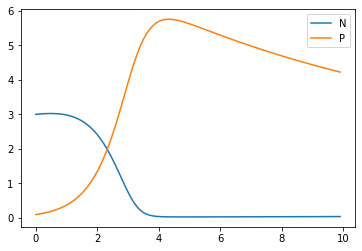

In [11]:
time = odeint_out.Time__time

plt.plot(time, odeint_out.Nutrient__var_value, label='N')
#plt.plot(time, odeint_out.Nutrient2__var_value, label='N2')
plt.plot(time, odeint_out.Phytoplankton__var_value.T, label='P')
#plt.ylim(bottom=0)
plt.legend()

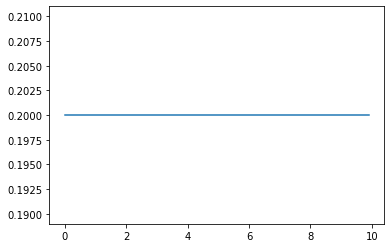

In [12]:
plt.plot(time, odeint_out.Input__input_value, label='N Input')

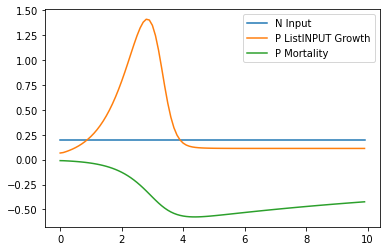

In [13]:
plt.plot(time, odeint_out.Input__input_value, label='N Input')
plt.plot(time, odeint_out.Growth__growth_value.T, label='P ListINPUT Growth')
plt.plot(time, -odeint_out.Mortality__death_value, label='P Mortality')
plt.legend()

In [14]:
stepwise_setup = phydra.update_setup(model=NPZD, old_setup=odeint_setup, new_solver="stepwise")

In [15]:
with NPZD:
    stepwise_out = stepwise_setup.xsimlab.run()

initializing model backend
Initializing Model Time
Initializing component Nutrient
Initializing component Nutrient2
Initializing component Phytoplankton
Initializing component N0
forcing function is in directory: /Users/bpo/Documents/GitHub/phydra/prototypes
forcing_val: 2.0
Initializing component Input
Initializing component Monod
Initializing component ListInputFlux
Initializing component Mortality
Initializing component Growth
assembling model
SOLVER : <phydra.backend.solvers.StepwiseSolver object at 0x160355940>
Model is assembled:
Model contains: 
Variables:['time', 'N', 'N2', 'P'] 
Parameters:['N0_value', 'Input_rate', 'Monod_halfsat', 'ListInputFlux_halfsat', 'Mortality_rate', 'Growth_mu_max'] 
Forcings:['N0'] 
Fluxes:['Time_time_flux', 'Input_input', 'Monod_monod_lim', 'ListInputFlux_growth', 'Mortality_death', 'Growth_growth'] 
Full Model Dimensions:[('time', None), ('N', None), ('N2', None), ('P', None), ('Time_time_flux', None), ('Input_input', None), ('Monod_monod_lim', Non

In [16]:
stepwise_out

<xarray.Dataset>
Dimensions:                      (clock: 100, input_time: 100, resources: 2, time: 100)
Coordinates:
  * clock                        (clock) float64 0.0 0.1 0.2 0.3 ... 9.7 9.8 9.9
Dimensions without coordinates: input_time, resources, time
Data variables:
    Core__solver_type            <U8 'stepwise'
    Growth__consumer             <U1 'P'
    Growth__growth_value         (time) float64 0.06667 0.06667 ... 0.1127
    Growth__mu_max               float64 1.0
    Growth__resource             <U1 'N'
    Input__forcing               <U2 'N0'
    Input__input_value           (time) float64 0.2 0.2 0.2 0.2 ... 0.2 0.2 0.2
    Input__rate                  float64 0.1
    Input__var                   <U1 'N'
    ListInputFlux__consumer      <U1 'P'
    ListInputFlux__growth_value  (resources, time) float64 0.0375 ... 5.886e-08
    ListInputFlux__halfsat       int64 2
    ListInputFlux__resources     (resources) <U2 'N' 'N2'
    Monod__halfsat               float64 1.5
    Monod__monod_lim_label       <U15 'Monod_monod_lim'
    Monod__monod_lim_value       (time) float64 0.6667 0.6667 ... 0.02621
    Monod__resource              <U1 'N'
    Mortality__death_value       (time) float64 0.01 0.01 ... 0.4323 0.4299
    Mortality__rate              float64 0.1
    Mortality__var               <U1 'P'
    N0__forcing_label            <U2 'N0'
    N0__forcing_value            (time) float64 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0
    N0__value                    float64 2.0
    Nutrient2__var_init          float64 3.0
    Nutrient2__var_label         <U2 'N2'
    Nutrient2__var_value         (time) float64 3.0 2.996 ... 2.205e-08
    Nutrient__var_init           float64 3.0
    Nutrient__var_label          <U1 'N'
    Nutrient__var_value          (time) float64 3.0 3.01 ... 0.04037 0.0406
    Phytoplankton__var_init      float64 0.1
    Phytoplankton__var_label     <U1 'P'
    Phytoplankton__var_value     (time) float64 0.1 0.1132 ... 4.299 4.276
    Time__time                   (input_time) float64 0.0 0.1 0.2 ... 9.8 9.9

In [17]:
import matplotlib.pyplot as plt

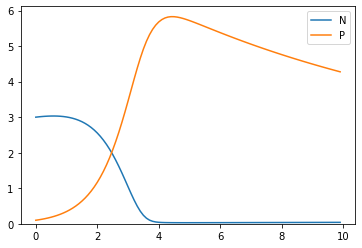

In [18]:
time = stepwise_out.Time__time

plt.plot(time, stepwise_out.Nutrient__var_value, label='N')
#plt.plot(time, stepwise_out.Nutrient2__var_value, label='N2')
plt.plot(time, stepwise_out.Phytoplankton__var_value.T, label='P')
plt.ylim(bottom=0)
plt.legend()

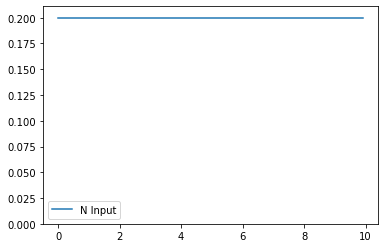

In [19]:
plt.plot(time, stepwise_out.Input__input_value, label='N Input')
plt.ylim(bottom=0)
plt.legend()

In [20]:
gekko_setup = phydra.update_setup(model=NPZD, 
                                  old_setup=odeint_setup, 
                                  new_solver="gekko", 
                                  # gekko solver works better (much faster) with smaller time steps:
                                  # new_time=np.arange(0,201,.1)
                                 )

In [21]:
with NPZD:
    gekko_out = gekko_setup.xsimlab.run()

initializing model backend
Initializing Model Time
Initializing component Nutrient
Initializing component Nutrient2
Initializing component Phytoplankton
Initializing component N0
forcing function is in directory: /Users/bpo/Documents/GitHub/phydra/prototypes
forcing_val: 2.0
Initializing component Input
Initializing component Monod
Initializing component ListInputFlux
Initializing component Mortality
Initializing component Growth
assembling model
SOLVER : <phydra.backend.solvers.GEKKOSolver object at 0x160533f40>
Model dicts are assembled:
Model contains: 
Variables:['time', 'N', 'N2', 'P'] 
Parameters:['N0_value', 'Input_rate', 'Monod_halfsat', 'ListInputFlux_halfsat', 'Mortality_rate', 'Growth_mu_max'] 
Forcings:['N0'] 
Fluxes:['Time_time_flux', 'Input_input', 'Monod_monod_lim', 'ListInputFlux_growth', 'Mortality_death', 'Growth_growth'] 
Full Model Dimensions:[('time', None), ('N', None), ('N2', None), ('P', None), ('Time_time_flux', None), ('Input_input', None), ('Monod_monod_lim',

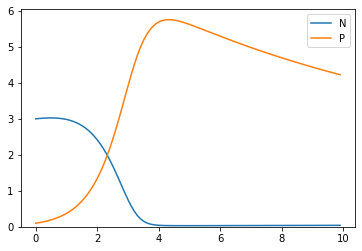

In [22]:
time = gekko_out.Time__time
plt.plot(time, gekko_out.Nutrient__var_value, label='N')
#plt.plot(time, gekko_out.Nutrient2__var_value, label='N2')
plt.plot(time, gekko_out.Phytoplankton__var_value.T, label='P')
plt.ylim(bottom=0)
plt.legend()

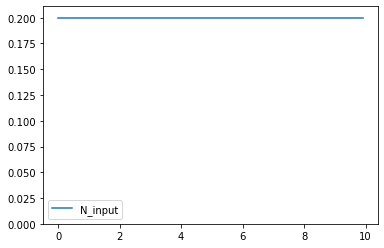

In [23]:
plt.plot(time, gekko_out.Input__input_value, label='N_input')
plt.ylim(bottom=0)
plt.legend()